In [1]:
#import the necessary libraries/packages

import pandas as pd
import numpy as np

In [3]:
#pandas has an option to read data from a text file, so let's use that

df = pd.read_csv('/Users/chidam/Desktop/3D_spatial_network.txt', sep=",", header=None)

In [4]:
df.head()

,0,1,2,3
0,144552912,9.349849,56.740876,17.052772
1,144552912,9.350188,56.740679,17.614840
2,144552912,9.350549,56.740544,18.083536
3,144552912,9.350806,56.740484,18.279465
4,144552912,9.351053,56.740486,18.422974


In [5]:
#let's check the length of the dataframe
len(df)

434874

In [6]:
#let's give the columns some names to identify them

df.rename(columns={0: "mapid", 1:"longitude", 2:"latitude", 3:"height"}, inplace=True)

In [7]:
#check the dataframe after naming the columns

df.head()

,mapid,longitude,latitude,height
0,144552912,9.349849,56.740876,17.052772
1,144552912,9.350188,56.740679,17.614840
2,144552912,9.350549,56.740544,18.083536
3,144552912,9.350806,56.740484,18.279465
4,144552912,9.351053,56.740486,18.422974


In [8]:
#next we have to check whether there are any missing values in the dataset

percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,'percent_missing': percent_missing})
missing_value_df

#result
#looks like there aren't any null values in the dataset

,column_name,percent_missing
mapid,mapid,0.0
longitude,longitude,0.0
latitude,latitude,0.0
height,height,0.0


In [9]:
#looks like there are repeated values present in the dataset

df["mapid"].value_counts()


#result
#there are many repeated values. we are talking about a 3D road network and therefore many points in a road are 
#demonstrated



131358199    557
137256876    491
126628907    407
8169309      314
137256823    252
            ... 
110525424      1
127833069      1
111141691      1
151709910      1
129772617      1
Name: mapid, Length: 57329, dtype: int64

In [10]:
#how many number of unique mapids are there in the dataset?


len(df["mapid"].unique())


57329

In [13]:
#Let's convert the latitude and longitude into radians and try 

# To convert to radians from decimal, multiply the decimal * pi/180. Then to convert back from radians to decimal, 
# multiply by 180/pi.


from math import pi
df['longitude']=df['longitude']*(pi/180)

In [14]:
#As a first step in feature transformation, I wanted to convert latitude and longitude into radians and 
df['longitude']=df['longitude']*(pi/180)



0         0.163186
1         0.163192
2         0.163198
3         0.163202
4         0.163207
            ...   
434869    0.173424
434870    0.173411
434871    0.173399
434872    0.173546
434873    0.173546
Name: longitude, Length: 434874, dtype: float64

In [15]:
df['latitude']=df['latitude']*(pi/180)

In [16]:
df_groupby=df.groupby("mapid").mean().reset_index()

In [17]:
df_groupby.head()

,mapid,longitude,latitude,height
0,4482444,0.173461,0.995197,37.739819
1,4550137,0.173094,0.995755,3.719121
2,4565214,0.173240,0.995580,3.202092
3,4579004,0.173321,0.995600,2.688183
4,4579009,0.173398,0.995903,14.128772


In [39]:
len(df_groupby)

57329

In [40]:
df_groupby.shape

(57329, 4)

In [41]:
#saving a copy of the grouped_by dataframe for future reference
df_groupby.to_csv('/Users/chidam/Desktop/3d_road_df_groupedby.csv')

In [25]:
Instead of converting the mapid column into a numpy array to create bins I used .values and .reshape for the conversion
in the cell below

arr=df_groupby.to_numpy(df_groupby['mapid'])

In [27]:
this is to show why we need .reshape
arr

array([[  4482444,         0,         0,        37],
       [  4550137,         0,         0,         3],
       [  4565214,         0,         0,         3],
       ...,
       [157742414,         0,         1,         1],
       [157742415,         0,         1,         2],
       [157742416,         0,         1,         2]])

In [33]:
to create bins using KBinsDiscretizer. here the huge assumption is that the mapids would have been issued in the order
they were created and therefore can cluster them in bins by treating them as ordinal data make sense.

from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')



In [34]:
est.fit(df_groupby['mapid'].values.reshape(-1, 1))

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [35]:

X_mapid= est.transform(df_groupby['mapid'].values.reshape(-1, 1))


In [37]:
X_mapid.shape

(57329, 1)

In [38]:
from numpy import savetxt
savetxt('/Users/chidam/Desktop/3D_road_mapid_10bins.csv', X_mapid, delimiter=',')

In [43]:
#let's read from the following file after adding the bin details to the dataset

df_groupby_bins=pd.read_csv('/Users/chidam/Desktop/3d_road_network_project/3d_road_df_groupedby.csv')

In [44]:
df_groupby_bins.head()

,mapid,longitude,latitude,height,mapid_bins
0,4482444,0.173461,0.995197,37.739819,0.0
1,4550137,0.173094,0.995755,3.719121,0.0
2,4565214,0.173240,0.995580,3.202092,0.0
3,4579004,0.173321,0.995600,2.688183,0.0
4,4579009,0.173398,0.995903,14.128772,0.0


In [45]:
#Let's check the unique values in the mapid_bins column

df_groupby_bins['mapid_bins'].value_counts()

6.0    16253
9.0     8609
7.0     7874
5.0     6827
8.0     6372
1.0     4344
2.0     3796
4.0     2166
0.0      594
3.0      494
Name: mapid_bins, dtype: int64

In [47]:
#let's define our target label. 
#.values will give us a list of values of y. because we send a numpy array of values as input into a model .values works great
#.values gives us a numpy array of values 

Y=df_groupby_bins["height"].values


In [48]:
#remove the labels from the dataset before assigning it to X
df_groupby_bins.drop("height", axis=1, inplace=True)

In [49]:
#remove mapid from the dataset (as I have the info in the mapid_bins column) before assigning it to X
df_groupby_bins.drop("mapid", axis=1, inplace=True)

In [50]:
df_groupby_bins.head()

,longitude,latitude,mapid_bins
0,0.173461,0.995197,0.0
1,0.173094,0.995755,0.0
2,0.173240,0.995580,0.0
3,0.173321,0.995600,0.0
4,0.173398,0.995903,0.0


In [51]:
X=df_groupby_bins.values

In [52]:
#let's split the dataset into train and test 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [53]:
#let's invoke sklearn linear regression. can also use scipy's linear regression

from sklearn import linear_model
reg = linear_model.LinearRegression()


In [54]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
#let's predict using X_test
y_predict=reg.predict(X_test)

In [56]:
y_predict

array([20.40564906, 20.13805935, 18.23184906, ..., 26.5752408 ,
       20.55529521, 21.23015757])

In [57]:
#the ground truth values
y_test


array([36.49805222, 22.49857577, 60.60848575, ..., 30.10544492,
       16.89447561,  6.87382348])

In [58]:
len(y_predict)

11466

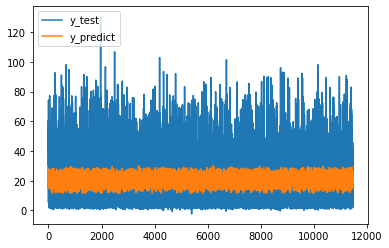

In [60]:
#Let's plot the predicted y values Vs. the ground truth using matplotlib

import matplotlib.pyplot as plt
import numpy as np


x=np.arange(11466)

# plt.gca().set_color_cycle(['red', 'green'])

plt.plot(x, y_test)
plt.plot(x, y_predict)

plt.legend(['y_test', 'y_predict'], loc='upper left')

plt.show()

In [ ]:
Result

From the above plot it is clear that the y_predict is way off from the y_test

two things are different in this notebook:
1. latitude and longitude are converted into radians and then their average values were calculated
2. the mapids are converted into 10 bins and the info is used as a feature

Its clear that these transformations are not enough to capture the relationship between the features in order to determine
the height in the test set.